<div align='center'>

# Transfer Learning and Fine-tuning
    
</div>

This is an additional lab to Lab05, which try many models to predict for the CIFAR-10

## 1. Import the neccessary pakages

Notebook Colors:


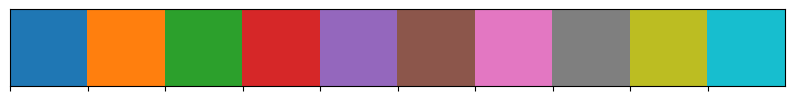

In [1]:
# Import the neccessary packages
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, Sequential, Model
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns

class clr:
    # Reset
    E = "\033[0m"
    # Colors
    R = "\033[91m"   # Red
    G = "\033[92m"   # Green
    Y = "\033[93m"   # Yellow
    B = "\033[94m"   # Blue
    M = "\033[95m"   # Magenta
    C = "\033[96m"   # Cyan
    W = "\033[97m"   # White

my_colors = [
    "#1f77b4",  # blue
    "#ff7f0e",  # orange
    "#2ca02c",  # green
    "#d62728",  # red
    "#9467bd",  # purple
    "#8c564b",  # brown
    "#e377c2",  # pink
    "#7f7f7f",  # gray
    "#bcbd22",  # yellow-green
    "#17becf"   # cyan
]

print(clr.G+'Notebook Colors:'+clr.E)
sns.palplot(sns.color_palette(my_colors))
plt.show()

In [2]:
# Load the training and testing data from the CIFAR 10 DATASET
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Original batch shape: (9, 32, 32, 3)
Labels shape: (9, 1)


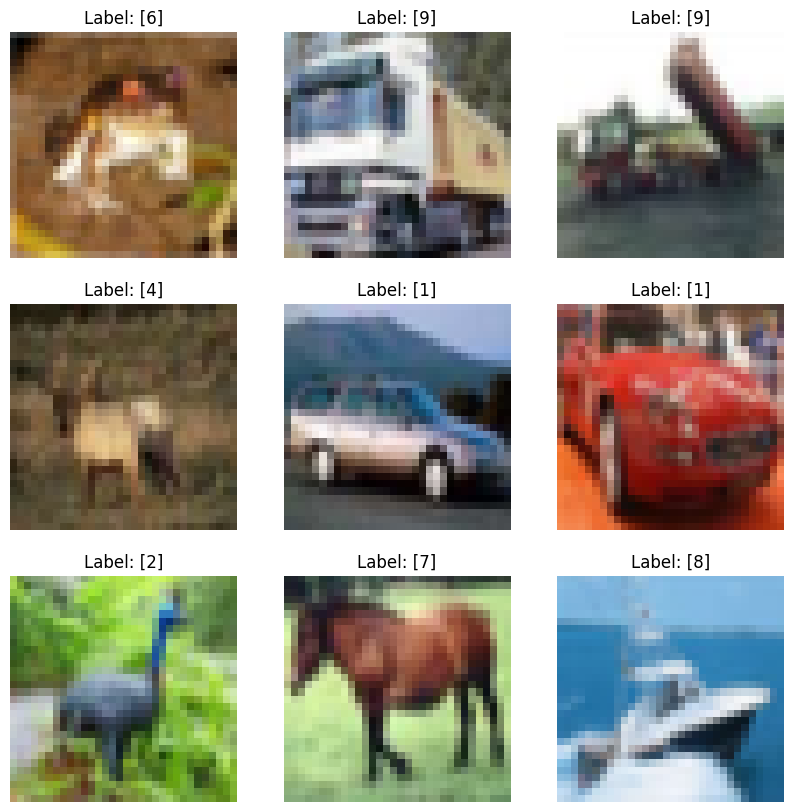

In [3]:
# Visualize the original images
raw_train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(9)

for images, labels in raw_train_dataset.take(1):
    print("Original batch shape:", images.shape)
    print("Labels shape:", labels.shape)

    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # original format
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")

## 2. Data Preprocessing

### 3.1 - Define the train_dataset and test_dataset for each model

Create a function to preprocess input based on the model we want to use

In [4]:
# Using df.data.AUTOTUNE for faster training time and efficiency
AUTOTUNE = tf.data.AUTOTUNE

In [5]:
# Import the models
from tensorflow.keras.applications import (
    vgg16, vgg19, resnet, resnet_v2,
    inception_v3, mobilenet_v2,
    efficientnet
)


In [6]:
MODEL_CONFIGS = {
    "VGG16": (vgg16.preprocess_input, (224, 224), tf.keras.applications.VGG16),
    "VGG19": (vgg19.preprocess_input, (224, 224), tf.keras.applications.VGG19),
    "ResNet50": (resnet.preprocess_input, (224, 224), tf.keras.applications.ResNet50),
    "ResNet101": (resnet.preprocess_input, (224, 224), tf.keras.applications.ResNet101),
    "InceptionV3": (inception_v3.preprocess_input, (299, 299), tf.keras.applications.InceptionV3),
    "MobileNetV2": (mobilenet_v2.preprocess_input, (160, 160), tf.keras.applications.MobileNetV2),
    "EfficientNetB0": (efficientnet.preprocess_input, (224, 224), tf.keras.applications.EfficientNetB0),
}

In [7]:
# Create a function create_dataset to load the train_daset and test_dataset based on the chosen model of the users
def create_dataset(train_images, train_labels, test_images, test_labels, batch_size, model_name):

    # raise the error if the model is not in the configs
    if model_name not in MODEL_CONFIGS:
        raise ValueError(clr.R+f"Unsupported model: {model_name}. Supported models: {list(MODEL_CONFIGS.keys())}"+clr.E)

    # load the preprocess_input and the image size from the configs
    preprocess_input, img_size, base_model = MODEL_CONFIGS[model_name]

    # function to resize the image and preprocess the input
    # we create this function so it can be used inside the input pipeline
    def preprocess(x, y):
        x = tf.image.resize(x, img_size) # resize the image
        x = preprocess_input(x) # preprocess the input
        return x, y

    # Create training dataset
    train_dataset = (
        tf.data.Dataset.from_tensor_slices((train_images, train_labels))
        .cache() # use cache() for faster training
        .shuffle(10000)
        .map(preprocess, num_parallel_calls=AUTOTUNE) # preprocess multiple images based on the CPU
        .batch(batch_size)
        .prefetch(AUTOTUNE)
    )

    # Create test dataset
    test_dataset = (
        tf.data.Dataset.from_tensor_slices((test_images, test_labels))
        .cache() # use cache() for faster training
        .map(preprocess, num_parallel_calls=AUTOTUNE) # preprocess multiple images based on the CPU
        .batch(batch_size)
        .prefetch(AUTOTUNE)
    )

    print(clr.G+f"Dataset prepared for {model_name} with input size {img_size}"+clr.E)
    return train_dataset, test_dataset

### 3.2 - Check for the number of layers in each model

Check the number layers in each model so that we could choose from which layer to fine-tune from

In [8]:
# A dictionary of the models we will use
models = {
    "VGG16": tf.keras.applications.VGG16(weights='imagenet', include_top=False),
    "VGG19": tf.keras.applications.VGG19(weights='imagenet', include_top=False),
    "ResNet50": tf.keras.applications.ResNet50(weights='imagenet', include_top=False),
    "ResNet101": tf.keras.applications.ResNet101(weights='imagenet', include_top=False),
    "InceptionV3": tf.keras.applications.InceptionV3(weights='imagenet', include_top=False),
    "MobileNetV2": tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False),
    "EfficientNetB0": tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False),
}

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/tmp/ipython-input-3797714584.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  "MobileNetV2": tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
# Print the number of layers in each model
for name, model in models.items():
    print(f"{name}: {len(model.layers)} layers")

VGG16: 19 layers
VGG19: 22 layers
ResNet50: 175 layers
ResNet101: 345 layers
InceptionV3: 311 layers
MobileNetV2: 154 layers
EfficientNetB0: 238 layers


## 3. Build the model

Create a function to build the model

In [10]:
def build_model(model_name, num_classes=10, fine_tune_from=None, dropout_rate=0.3):
    """
    Builds and compiles a transfer learning model based on the user's chosen model.

    Parameters:
    - model_name: str, model key from MODEL_CONFIGS
    - num_classes: int, number of output classes
    - fine_tune_from: int or None, layer index to start fine-tuning from
    - dropout_rate: float, dropout rate for regularization
    """
    if model_name not in MODEL_CONFIGS:
        raise ValueError(clr.R+f"Unsupported model '{model_name}'. Supported models: {list(MODEL_CONFIGS.keys())}"+clr.E)

    preprocess_input, img_size, base_model_class = MODEL_CONFIGS[model_name]

    # Build base model
    base_model = base_model_class(
        include_top=False,
        weights='imagenet',
        input_shape=img_size + (3,)
    )

    # Freeze all layers initially
    base_model.trainable = False

    # Define data augmentation
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.05),
        tf.keras.layers.RandomZoom(0.05),
    ])

    # Build full model
    inputs = Input(shape=img_size + (3,))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)

    # Compile initial frozen model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    # === Fine-tuning logic ===
    if fine_tune_from is not None:

        base_model.trainable = True

        total_layers = len(base_model.layers)

        for layer in base_model.layers[:fine_tune_from]:
            layer.trainable = False

        print(clr.G+f"Fine-tuning '{model_name}' from layer {fine_tune_from}/{total_layers}"+clr.E)

        # Recompile with lower learning rate for fine-tuning
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=['accuracy']
        )
    else:
        print(clr.G+f"Model '{model_name}' built with frozen base layers."+clr.E)

    return model


In [11]:
# Define optimal fine-tuning layers for each model
FINE_TUNE_POINTS = {
    "VGG16": 10,
    "VGG19": 15,
    "ResNet50": 140,
    "ResNet101": 250,
    "InceptionV3": 230,
    "MobileNetV2": 100,
    "EfficientNetB0": 170,
}

histories = {}
fine_tuned_models = {}
BATCH_SIZE = 128

# Callbacks
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

# Loop through each model
for model_name, fine_tune_at in FINE_TUNE_POINTS.items():
    print(clr.G + f"\n--- Processing {model_name} ---" + clr.E)

    # Create dataset
    train_dataset, test_dataset = create_dataset(
        train_images, train_labels, test_images, test_labels, BATCH_SIZE, model_name
    )

    # PHASE 1: FEATURE EXTRACTION
    print(clr.C + f"\n[1] Feature Extraction for {model_name}..." + clr.E)
    model = build_model(model_name, num_classes=10, fine_tune_from=None)  # Freeze entire base

    history_feature = model.fit(
        train_dataset,
        validation_data=test_dataset,
        epochs=10,   # smaller number of epochs for this phase
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    # PHASE 2: FINE-TUNING
    print(clr.C + f"\n[2] Fine-tuning {model_name} from layer {fine_tune_at}..." + clr.E)
    model = build_model(model_name, num_classes=10, fine_tune_from=fine_tune_at)  # Unfreeze top layers

    history_finetune = model.fit(
        train_dataset,
        validation_data=test_dataset,
        epochs=20,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    # Store both histories
    histories[model_name] = {
        "feature_extraction": history_feature,
        "fine_tuning": history_finetune
    }
    fine_tuned_models[model_name] = model

print(clr.G + "\n All models trained successfully with feature extraction and fine-tuning!" + clr.E)



--- Processing VGG16 ---
Dataset prepared for VGG16 with input size (224, 224)

[1] Feature Extraction for VGG16...
Model 'VGG16' built with frozen base layers.
Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 44s 95ms/step - accuracy: 0.3830 - loss: 3.4403 - val_accuracy: 0.7450 - val_loss: 0.7814 - learning_rate: 0.0010
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 35s 89ms/step - accuracy: 0.6735 - loss: 1.0345 - val_accuracy: 0.7741 - val_loss: 0.6621 - learning_rate: 0.0010
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 35s 89ms/step - accuracy: 0.7142 - loss: 0.8465 - val_accuracy: 0.7856 - val_loss: 0.6239 - learning_rate: 0.0010
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 35s 89ms/step - accuracy: 0.7207 - loss: 0.8171 - val_accuracy: 0.7869 - val_loss: 0.6207 - learning_rate: 0.0010
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 35s 89ms/step - accuracy: 0.7270 - loss: 0.7922 - val_accuracy: 0.7829 - val_loss: 0.6294 - learning_rate: 0.0010
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 35s 89ms/step - accuracy: 0.


Plotting VGG16 learning curves...


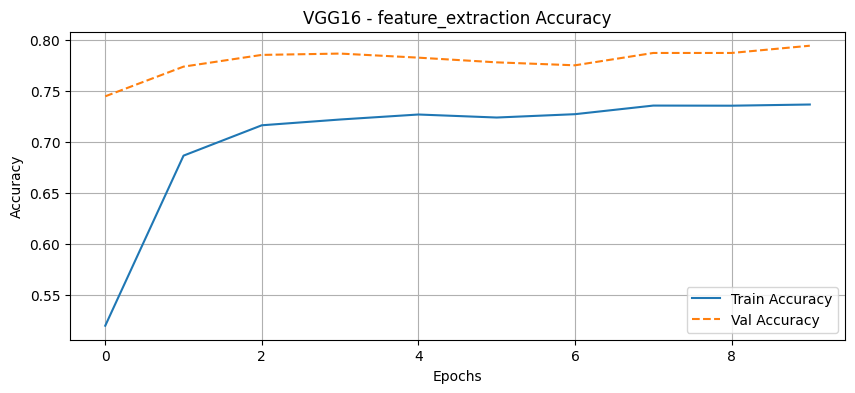

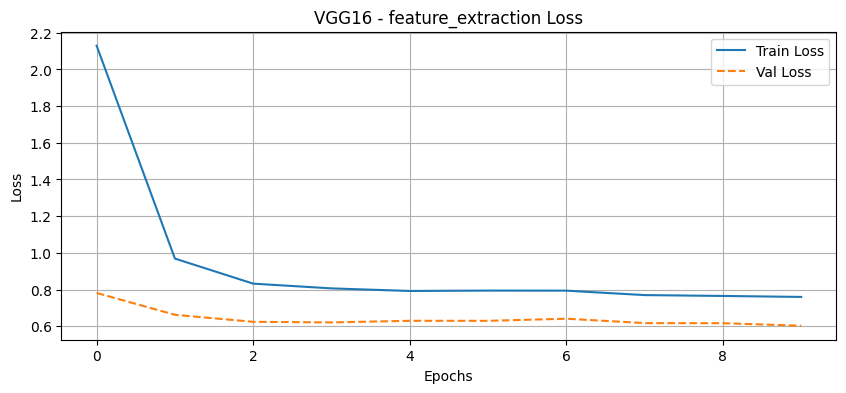

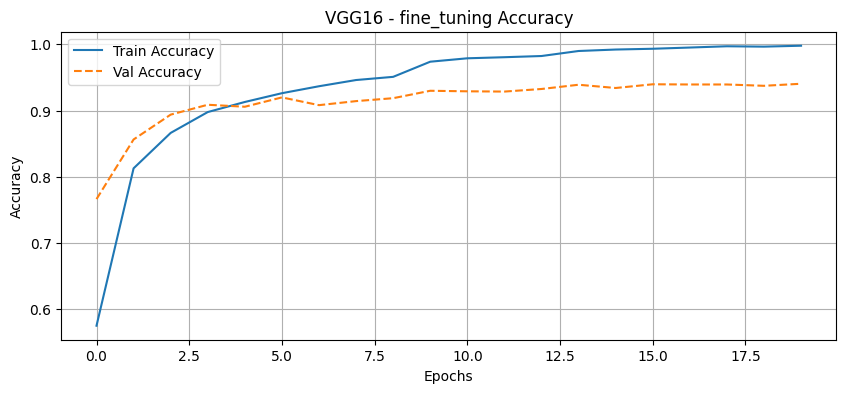

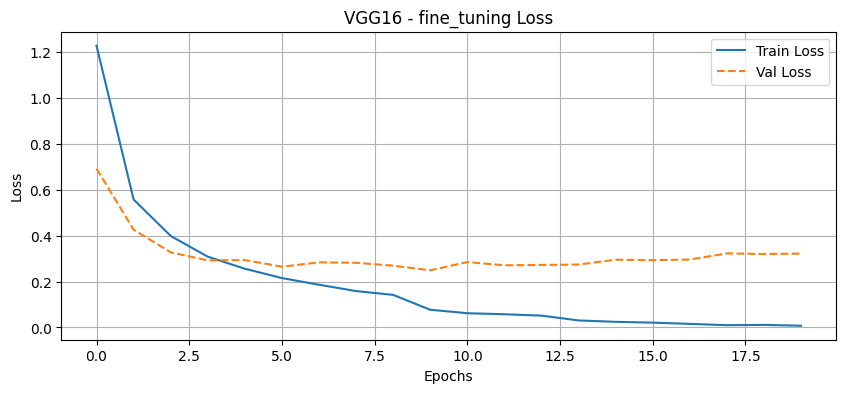


Plotting VGG19 learning curves...


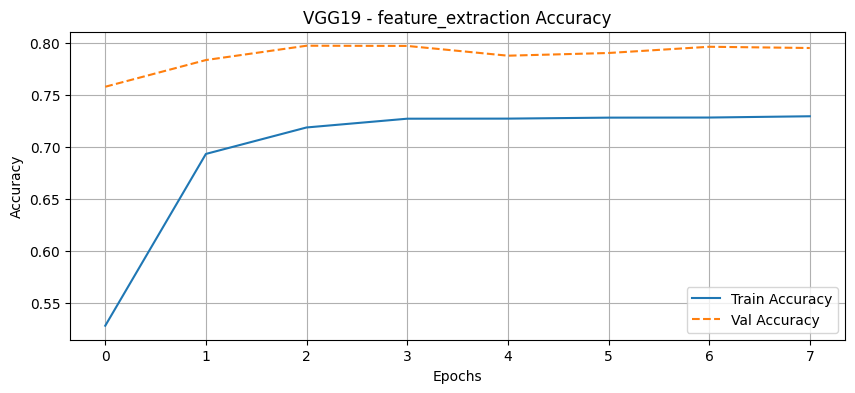

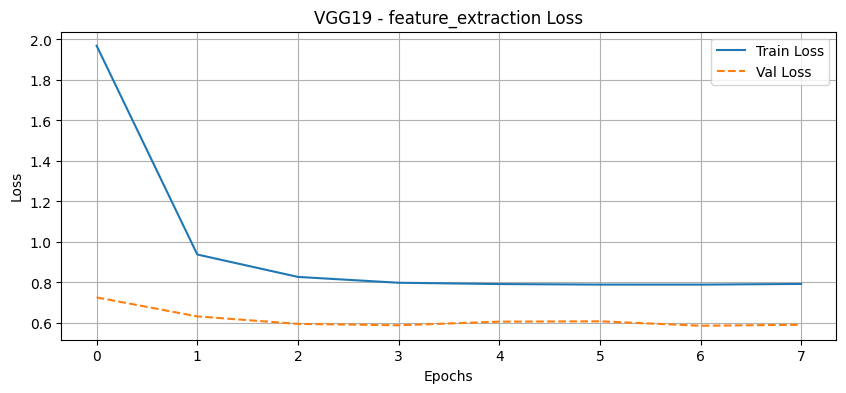

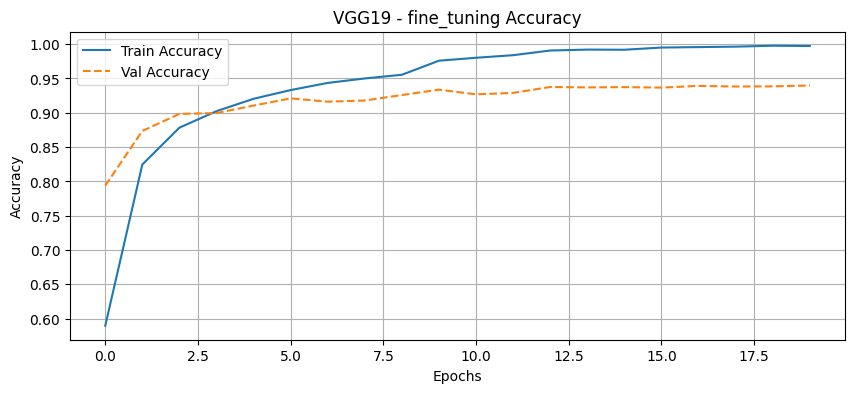

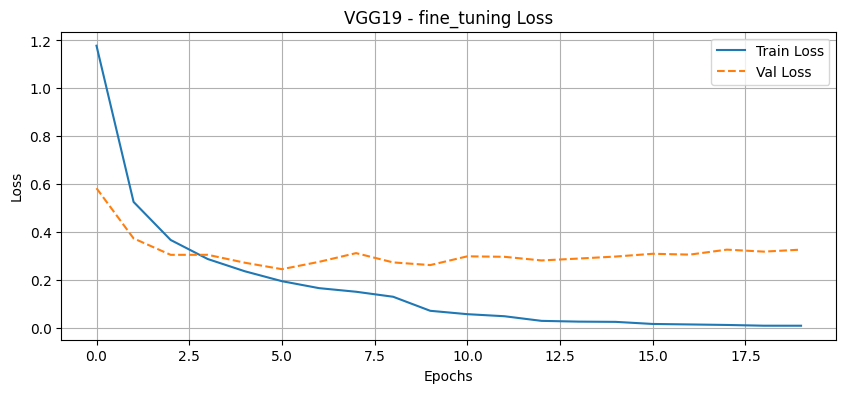


Plotting ResNet50 learning curves...


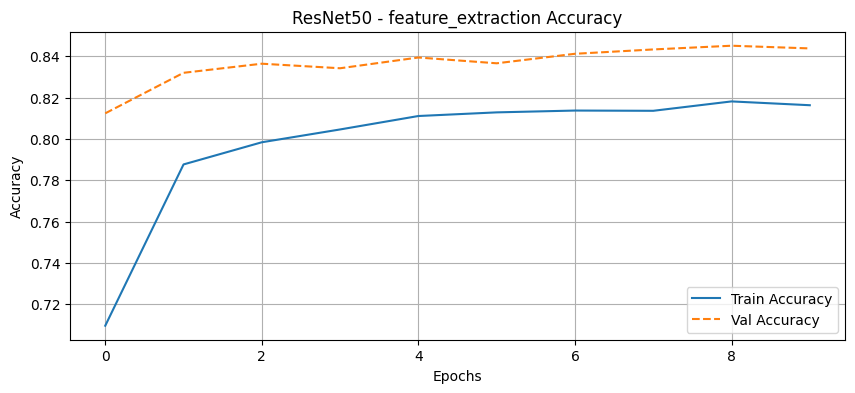

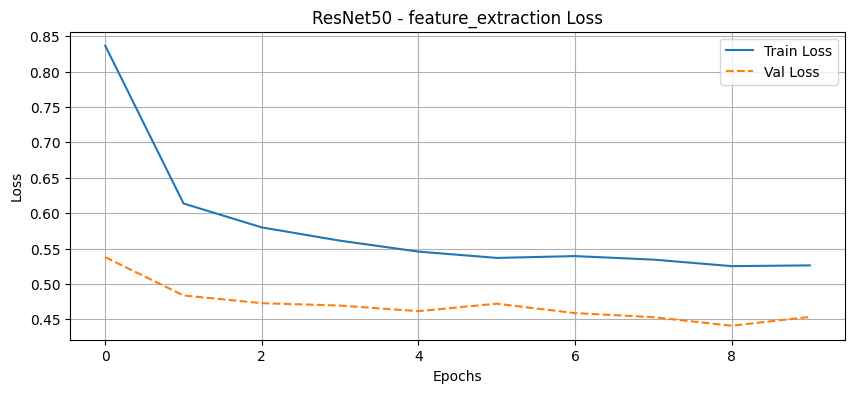

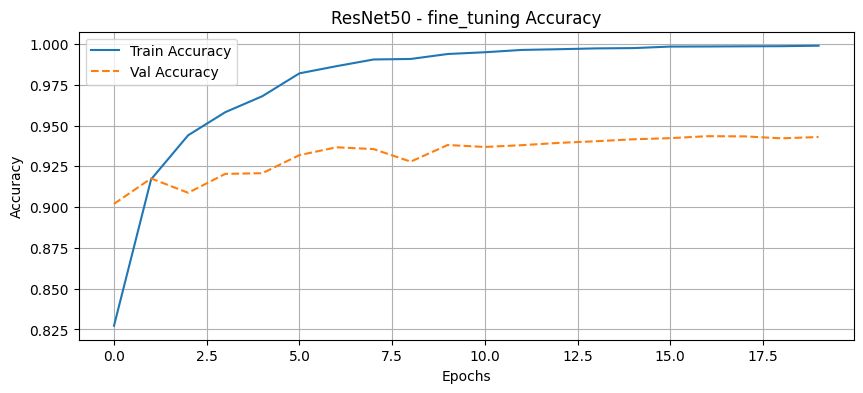

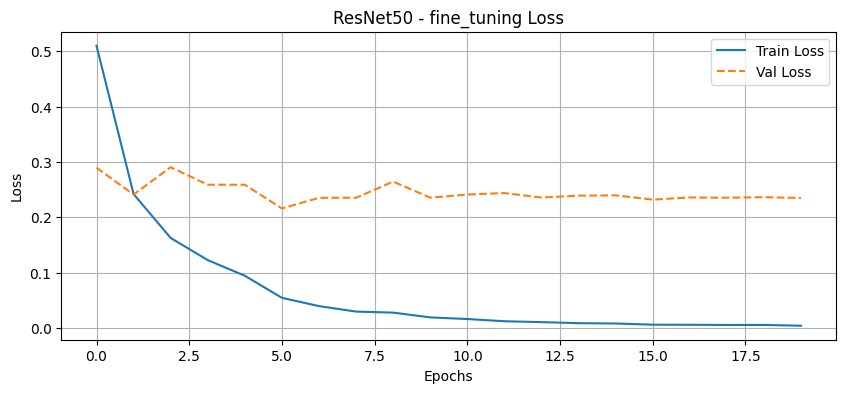


Plotting ResNet101 learning curves...


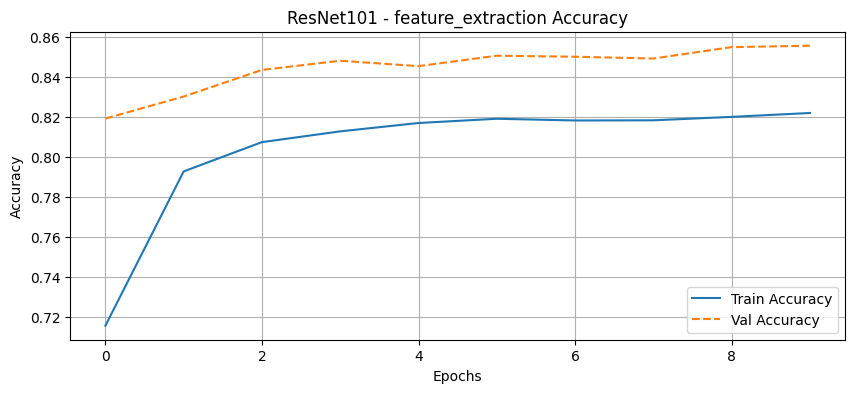

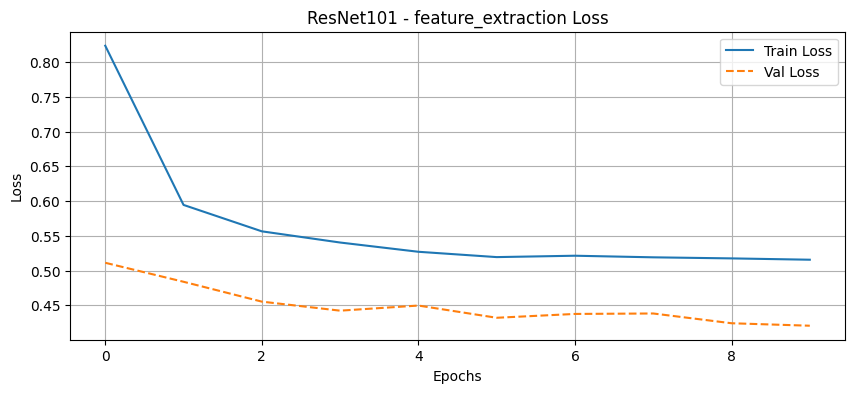

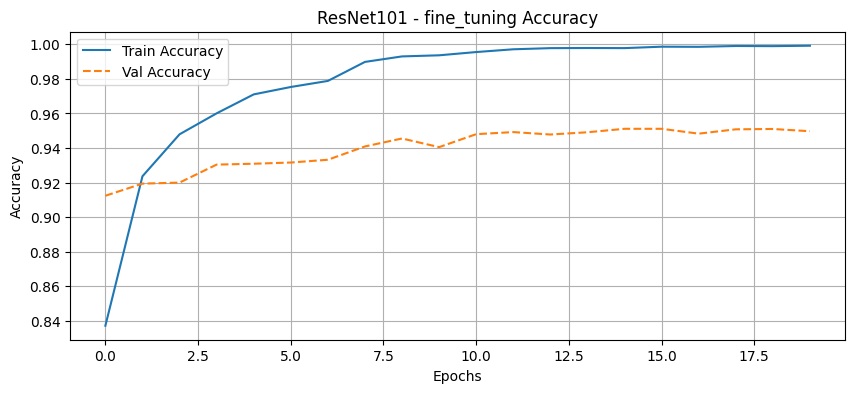

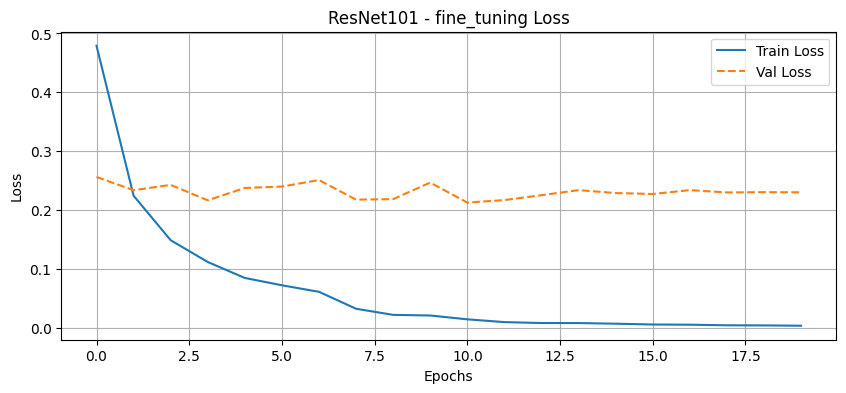


Plotting InceptionV3 learning curves...


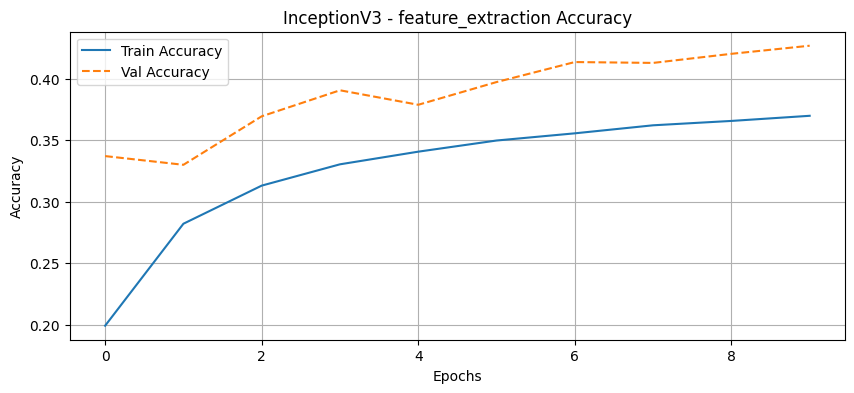

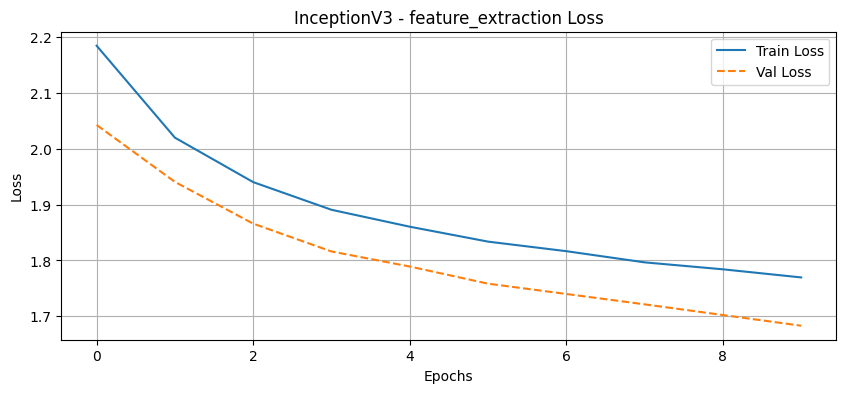

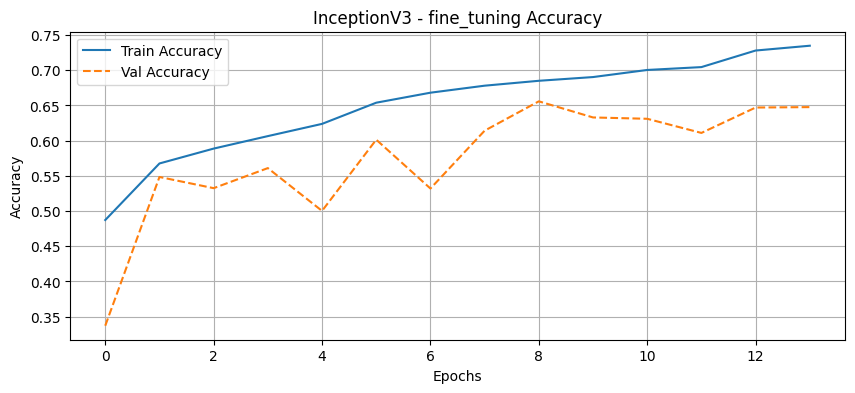

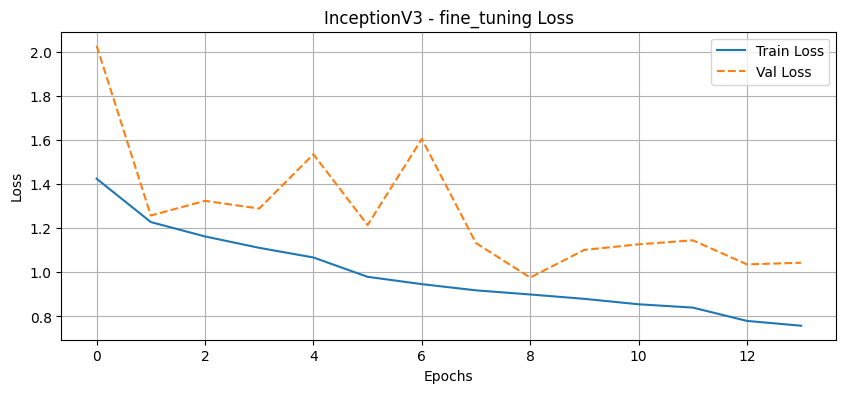


Plotting MobileNetV2 learning curves...


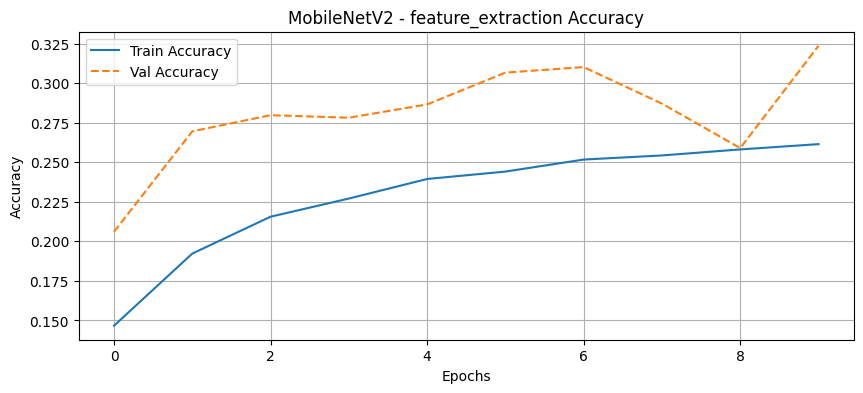

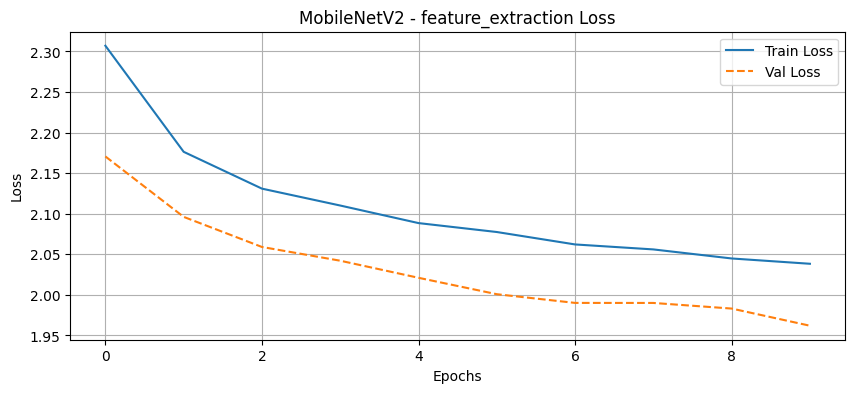

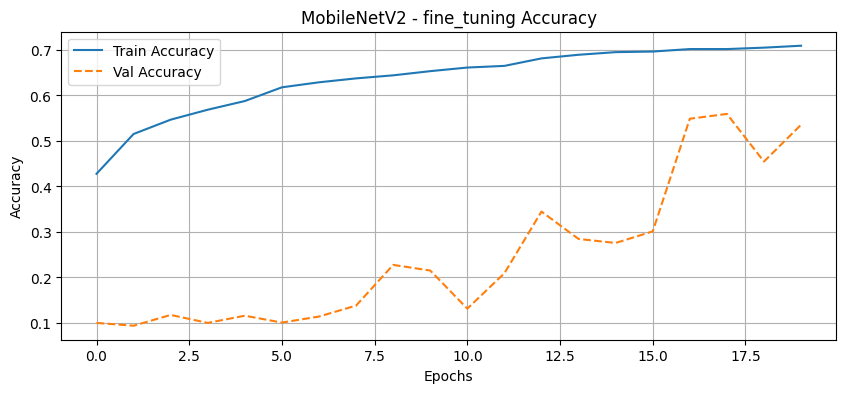

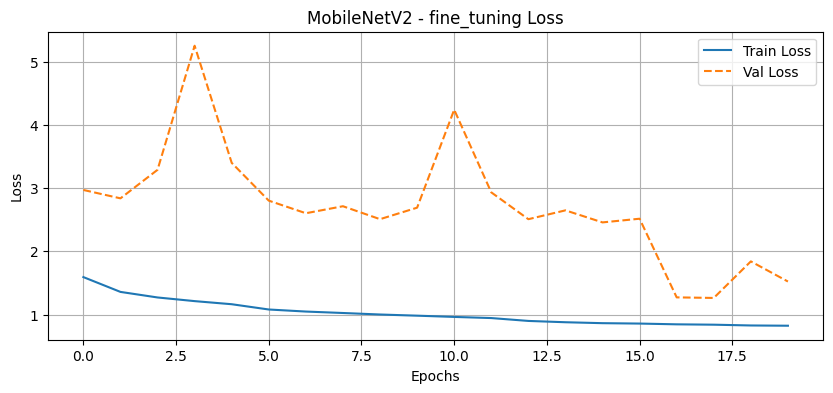


Plotting EfficientNetB0 learning curves...


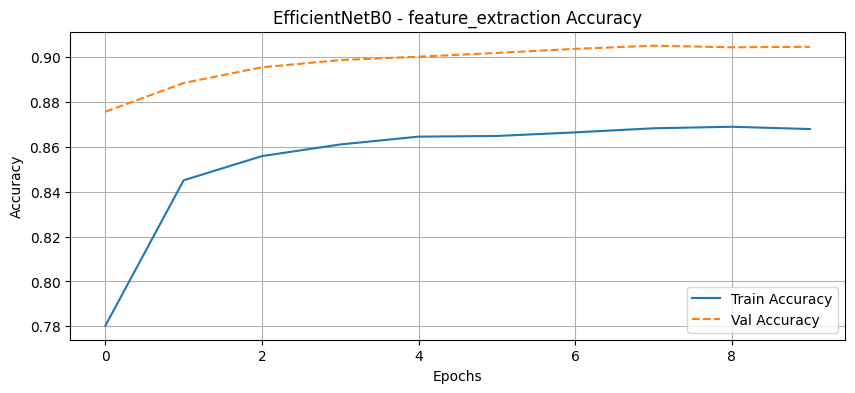

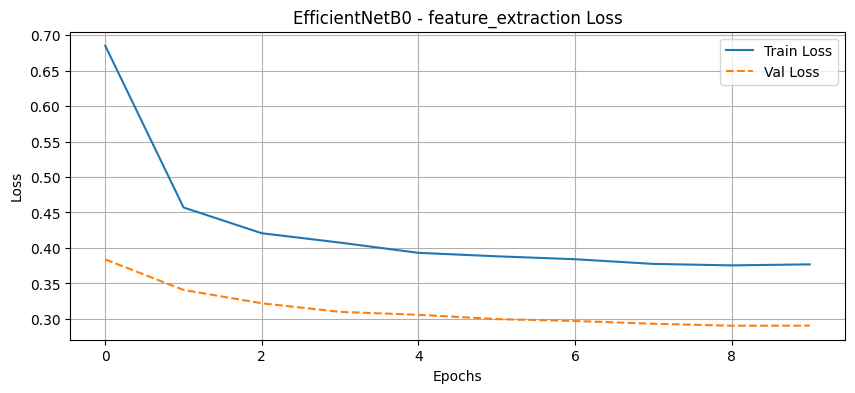

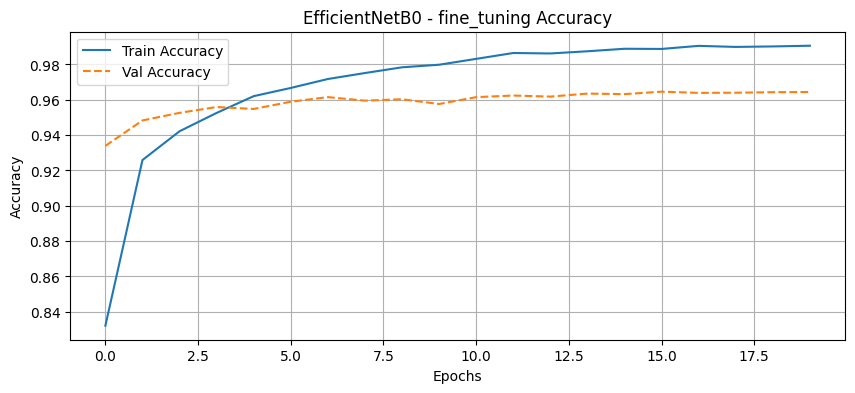

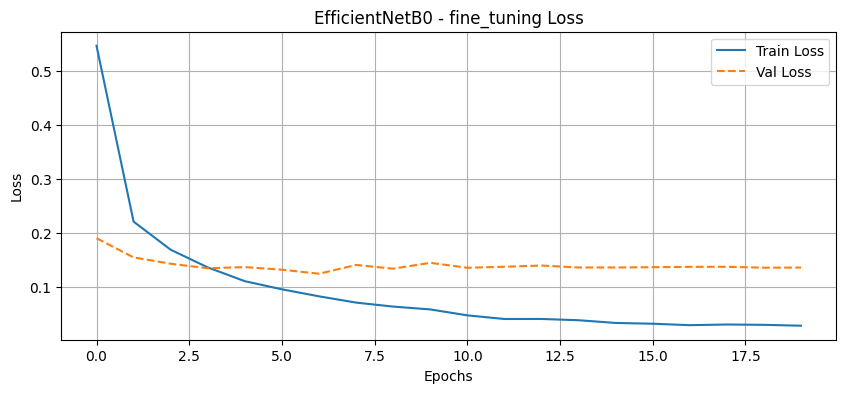

In [14]:
def plot_model_curves(histories):
    for name, phases in histories.items():
        print(f"\nPlotting {name} learning curves...")

        for phase_name, history in phases.items():
            plt.figure(figsize=(10, 4))

            # Accuracy plot
            plt.plot(history.history['accuracy'], label='Train Accuracy')
            plt.plot(history.history['val_accuracy'], linestyle='--', label='Val Accuracy')
            plt.title(f'{name} - {phase_name} Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.grid(True)
            plt.show()

            # Loss plot
            plt.figure(figsize=(10, 4))
            plt.plot(history.history['loss'], label='Train Loss')
            plt.plot(history.history['val_loss'], linestyle='--', label='Val Loss')
            plt.title(f'{name} - {phase_name} Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)
            plt.show()

plot_model_curves(histories)

In [17]:
import pandas as pd
import numpy as np

def summarize_results(histories):
    results = []
    for name, phases in histories.items():
        fine_tune_history = phases["fine_tuning"]
        hist = fine_tune_history.history

        # Get index of the best validation accuracy
        best_epoch = np.argmax(hist['val_accuracy'])

        results.append({
            'Model': name,
            'Best Epoch': best_epoch + 1,  # +1 because epochs start from 0
            'Train Accuracy (Best)': round(hist['accuracy'][best_epoch], 4),
            'Val Accuracy (Best)': round(hist['val_accuracy'][best_epoch], 4),
            'Val Loss (Best)': round(hist['val_loss'][best_epoch], 4)
        })

    df = pd.DataFrame(results).sort_values(by='Val Accuracy (Best)', ascending=False)
    return df

results_df = summarize_results(histories)
print(results_df)


            Model  Best Epoch  Train Accuracy (Best)  Val Accuracy (Best)  \
6  EfficientNetB0          16                 0.9888               0.9646   
3       ResNet101          15                 0.9978               0.9511   
2        ResNet50          17                 0.9985               0.9435   
0           VGG16          20                 0.9979               0.9405   
1           VGG19          20                 0.9973               0.9398   
4     InceptionV3           9                 0.6851               0.6559   
5     MobileNetV2          18                 0.7018               0.5593   

   Val Loss (Best)  
6           0.1369  
3           0.2287  
2           0.2358  
0           0.3219  
1           0.3261  
4           0.9765  
5           1.2633  
